Clear memory

In [1]:
%reset -f
import gc
gc.collect()

0

### Import libraries

In [2]:
import pandas as pd
import seaborn as sns
import torch
from torch import nn
from torch import optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Subset, random_split
sns.set_style('whitegrid')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from scripts import *
device = 'cuda' if torch.cuda.is_available() else 'cpu'
%matplotlib inline

### Set random seeds for reproducibility 

Use custom function to set all seeds manually

In [3]:
set_seed(42)

# Data preparation

## Define data transforms

Define mean and standart deviation as parameters of normalization

In [4]:
img_mean = [0.4914, 0.4822, 0.4465]
img_std = [0.2470, 0.2435, 0.2616]

Define transforms. Add three simple augmentations to train transform

In [5]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=img_mean, std=img_std),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=img_mean, std=img_std),
])

## Load and filter dataset

Load train dataset

In [6]:
train_data = datasets.CIFAR10(
    root='data',
    train=True,
    transform=transform_train,
    target_transform=None,
    download=True,
)

Load test data

In [7]:
test_data = datasets.CIFAR10(
    root='data',
    train=False,
    transform=transform_test,
    target_transform=None,
    download=True,
)

### Choose the target classes 

Print all class names with indexes in dataset

In [8]:
print(train_data.class_to_idx)

{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}


Select only 3 target classes to reduce computational load. Create a mapping to re-index these classes.

In [9]:
target_classes = ['bird', 'cat', 'dog']
target_class_to_idx = {k:v for v,k in enumerate(target_classes)}
target_class_indices = [train_data.class_to_idx[c] for c in target_classes]
target_class_to_idx_old = {k:v for k,v in train_data.class_to_idx.items() if k in target_classes}

In [10]:
print('List of indices of target classes: ', target_class_indices)
print('Target class to index new dictionsary:', target_class_to_idx)
print('Target class to index old dictionsary:', target_class_to_idx_old)

List of indices of target classes:  [2, 3, 5]
Target class to index new dictionsary: {'bird': 0, 'cat': 1, 'dog': 2}
Target class to index old dictionsary: {'bird': 2, 'cat': 3, 'dog': 5}


Filter classes (leave three target classes only)

In [11]:
def filter_by_class(dataset, allowed_indices):
    indices = [i for i, (_, label) in enumerate(dataset) if label in allowed_indices]
    return Subset(dataset, indices)

In [12]:
train_data = filter_by_class(train_data, target_class_indices)
test_data = filter_by_class(test_data, target_class_indices)

Define remap dictionary

In [13]:
remap_dict = {target_class_to_idx_old[i]:target_class_to_idx[i] for i in target_classes}
remap_dict

{2: 0, 3: 1, 5: 2}

Remap target classes indices

In [14]:
remap_target = lambda label: remap_dict[label]

train_data.dataset.target_transform = remap_target
test_data.dataset.target_transform = remap_target

In [15]:
target_classes, target_class_to_idx

(['bird', 'cat', 'dog'], {'bird': 0, 'cat': 1, 'dog': 2})

Split train dataset into train and val dataset (80/20 split)

In [16]:
train_len = int(0.8 * len(train_data))
val_len = len(train_data) - train_len

train_subset, val_subset = random_split(
    dataset=train_data,
    lengths=[train_len, val_len],
    generator=torch.Generator().manual_seed(42)
)

### Create PyTorch DataLoaders

Define the size of the mini batch

In [17]:
BATCH_SIZE = 32

Create DataLoader for train set

In [18]:
train_data_loader = DataLoader(
    dataset=train_subset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

Create DataLoader for val set

In [19]:
val_data_loader = DataLoader(
    dataset=val_subset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

Create DataLoader for test set

In [20]:
test_data_loader = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

## Visualization

First, we can plot some samples from train data

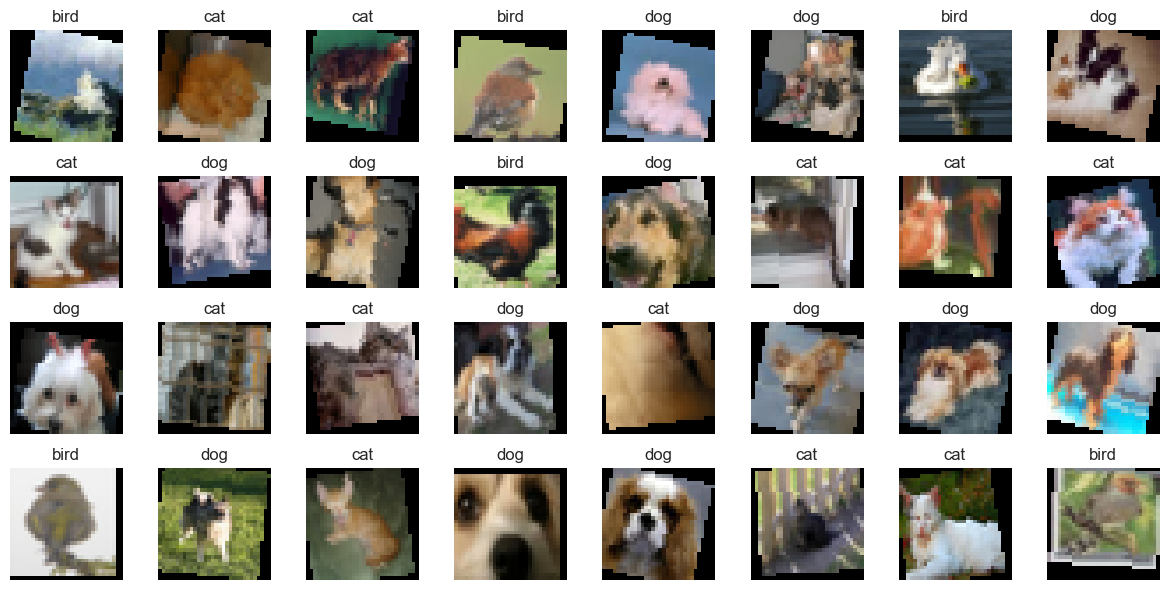

In [21]:
plot_samples_from_dataloader(train_data_loader, target_classes, R=BATCH_SIZE, mean=img_mean, std=img_std)

Second, we can analyze target classes distribution

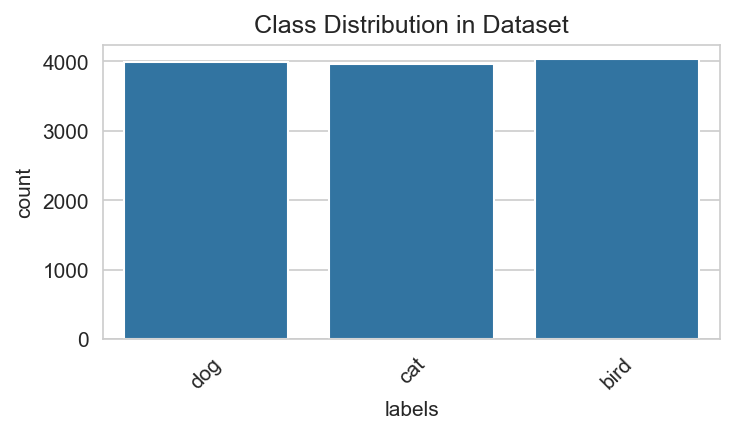

In [22]:
plot_target_classes_distribution_in_dataset(train_subset, target_classes)

Target classes are balanced very well

Final inspection of the prepared datasets.

In [23]:
print("Total train samples:", len(train_data_loader.dataset))
print("Total train batches:", len(train_data_loader))

print("Total val samples:", len(val_data_loader.dataset))
print("Total val batches:", len(val_data_loader))

print("Total test samples:", len(test_data_loader.dataset))
print("Total test batches:", len(test_data_loader))

Total train samples: 12000
Total train batches: 375
Total val samples: 3000
Total val batches: 94
Total test samples: 3000
Total test batches: 94


# Model Architecture 

Define a reusable convolutional block that applies a 2D convolution followed by batch normalization, ReLU activation, and 2×2 max pooling. This block can be stacked multiple times to build deeper convolutional neural network architectures

In [24]:
class ConvStack(nn.Module):
    def __init__(self, input_channels:int, output_channels:int):
        super().__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(
                in_channels=input_channels,
                out_channels=output_channels,
                kernel_size=3,
                padding=1,
                stride=1,
                bias=False,
            ),
            nn.BatchNorm2d(num_features=output_channels),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, padding=0, stride=2),
        )

    def forward(self, x):
        return self.conv_stack(x)

## Model V0

Define the first convolutional neural network model (ModelV0) using previously defined ConvStack module. The model architecture consists of two convolutional blocks followed by a linear classification head. Also, inherit from the ModelUtilsMixin class to add utility methods for saving, loading, counting parameters, and inference

In [25]:
class ModelV0(ModelUtilsMixin, nn.Module):
    def __init__(self, input_shape:int, input_channels:int=3, output_classes:int=10, hidden_channels:int=8):
        super().__init__()

        self.conv_stack_1 = ConvStack(input_channels=input_channels, output_channels=hidden_channels)

        self.conv_stack_2 = ConvStack(input_channels=hidden_channels, output_channels=hidden_channels*2)

        output_shape_of_last_conv_block = hidden_channels * 2
        num_maxpool_blocks = 2

        assert input_shape % (2 ** num_maxpool_blocks) == 0, \
            f"Input shape {input_shape} must be divisible by {2 ** num_maxpool_blocks}"

        flattened_size = (input_shape // 2**num_maxpool_blocks) ** 2 * output_shape_of_last_conv_block

        self.linear_stack_1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=flattened_size, out_features=output_classes),
        )

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        x = self.conv_stack_1(x)
        x = self.conv_stack_2(x)
        x = self.linear_stack_1(x)
        return x


## Model V1

In this version (ModelV1), we increase model complexity by adding a third convolutional block and applying dropout before the final linear layer. This helps improve generalization and reduce overfitting compared to the simpler baseline (ModelV0). The model still inherits from ModelUtilsMixin for utility support.

In [26]:
class ModelV1(ModelUtilsMixin, nn.Module):
    def __init__(self, input_shape:int, input_channels:int=3, output_classes:int=10, hidden_channels:int=16):
        super().__init__()

        self.conv_stack_1 = ConvStack(input_channels=input_channels, output_channels=hidden_channels)

        self.conv_stack_2 = ConvStack(input_channels=hidden_channels, output_channels=hidden_channels*2)

        self.conv_stack_3 = ConvStack(input_channels=hidden_channels*2, output_channels=hidden_channels*4)

        output_shape_of_last_conv_block = hidden_channels * 4
        num_maxpool_blocks = 3

        assert input_shape % (2 ** num_maxpool_blocks) == 0, \
            f"Input shape {input_shape} must be divisible by {2 ** num_maxpool_blocks}"

        flattened_size = (input_shape // 2**num_maxpool_blocks) ** 2 * output_shape_of_last_conv_block

        self.linear_stack_1 = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=flattened_size, out_features=output_classes)
        )

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        x = self.conv_stack_1(x)
        x = self.conv_stack_2(x)
        x = self.conv_stack_3(x)
        x = self.linear_stack_1(x)
        return x


## Model V2

ModelV2 significantly increases model depth by stacking four convolutional blocks and adding a two-layer fully connected head with dropout and non-linearity. This version aims to further improve performance by enhancing the model’s capacity to extract and process complex features

In [27]:
class ModelV2(ModelUtilsMixin, nn.Module):
    def __init__(self, input_shape:int, input_channels:int=3, output_classes:int=10, hidden_channels:int=32):
        super().__init__()

        self.conv_stack_1 = ConvStack(input_channels=input_channels, output_channels=hidden_channels)

        self.conv_stack_2 = ConvStack(input_channels=hidden_channels, output_channels=hidden_channels*2)

        self.conv_stack_3 = ConvStack(input_channels=hidden_channels*2, output_channels=hidden_channels*4)

        self.conv_stack_4 = ConvStack(input_channels=hidden_channels*4, output_channels=hidden_channels*8)

        output_shape_of_last_conv_block = hidden_channels * 8
        num_maxpool_blocks = 4

        assert input_shape % (2 ** num_maxpool_blocks) == 0, \
            f"Input shape {input_shape} must be divisible by {2 ** num_maxpool_blocks}"

        flattened_size = (input_shape // 2**num_maxpool_blocks) ** 2 * output_shape_of_last_conv_block

        self.linear_stack_1 = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=flattened_size, out_features=flattened_size//2),
            nn.ReLU(),
        )

        self.linear_stack_2 = nn.Sequential(
            nn.Dropout(p=0.3),
            nn.Linear(in_features=flattened_size//2, out_features=output_classes),
        )

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        x = self.conv_stack_1(x)
        x = self.conv_stack_2(x)
        x = self.conv_stack_3(x)
        x = self.conv_stack_4(x)
        x = self.linear_stack_1(x)
        x = self.linear_stack_2(x)
        return x


## Instantiate the models and move to device

In [28]:
model0 = ModelV0(input_shape=32, input_channels=3, output_classes=len(target_classes), hidden_channels=8)
model0 = model0.to(device=device)

model1 = ModelV1(input_shape=32, input_channels=3, output_classes=len(target_classes), hidden_channels=16)
model1 = model1.to(device=device)

model2 = ModelV2(input_shape=32, input_channels=3, output_classes=len(target_classes), hidden_channels=32)
model2 = model2.to(device=device)

Check the number of training parameters

In [29]:
print('Number of model0 parameters:', model0.count_params())
print('Number of model1 parameters:', model1.count_params())
print('Number of model2 parameters:', model2.count_params())

Number of model0 parameters: 4491
Number of model1 parameters: 26771
Number of model2 parameters: 915235


### Test models output shape 

In [30]:
first_batch, first_labels = next(iter(train_data_loader))

model0.eval()
with torch.inference_mode():
    first_logits = model0(first_batch.to(device=device))

print('Logits for the first image:', first_logits[0, :])
print('Shape of logits for the first minibatch:', first_logits.shape)

Logits for the first image: tensor([-0.0610,  0.0711,  0.2101])
Shape of logits for the first minibatch: torch.Size([32, 3])


In [31]:
first_batch, first_labels = next(iter(train_data_loader))

model1.eval()
with torch.inference_mode():
    first_logits = model1(first_batch.to(device=device))

print('Logits for the first image:', first_logits[0, :])
print('Shape of logits for the first minibatch:', first_logits.shape)

Logits for the first image: tensor([-0.0710,  0.1077,  0.1151])
Shape of logits for the first minibatch: torch.Size([32, 3])


In [32]:
first_batch, first_labels = next(iter(train_data_loader))

model1.eval()
with torch.inference_mode():
    first_logits = model2(first_batch.to(device=device))

print('Logits for the first image:', first_logits[0, :])
print('Shape of logits for the first minibatch:', first_logits.shape)

Logits for the first image: tensor([-0.4461,  0.0439, -0.2718])
Shape of logits for the first minibatch: torch.Size([32, 3])


# Model Training

Set up loss function 


In [33]:
loss_function = nn.CrossEntropyLoss()

Set up optimizers


In [34]:
optimizer0 = optim.Adam(params=model0.parameters(), lr=0.01)
optimizer1 = optim.Adam(params=model1.parameters(), lr=0.01)
optimizer2 = optim.Adam(params=model2.parameters(), lr=0.01)

Set up learning rate schedulers

In [35]:
scheduler0 = optim.lr_scheduler.ReduceLROnPlateau(optimizer0, mode='min', patience=5, factor=0.5, threshold=1e-5)
scheduler1 = optim.lr_scheduler.ReduceLROnPlateau(optimizer1, mode='min', patience=5, factor=0.5, threshold=1e-5)
scheduler2 = optim.lr_scheduler.ReduceLROnPlateau(optimizer2, mode='min', patience=5, factor=0.5, threshold=1e-5)

Implement early stopping to halt training if the validation loss fails to improve for a specified number of consecutive epochs

In [36]:
early_stopper = EarlyStopping(patience=15, min_delta=1e-4)

Define maximum number of epochs and epoch step to be logged

In [37]:
epochs = 1000
log_ep = 10

## Run training loop for each model

Implement a configurable training loop that supports early stopping, learning rate scheduling, and model checkpointing. Models are automatically saved during training loop and gradients are clipped to 5

Train model 0

In [38]:
model0_train_losses, model0_val_losses, model0_train_accuracies, model0_val_accuracies, _ = training_loop(
    model=model0,
    train_dataloader=train_data_loader,
    test_dataloader=val_data_loader,
    loss_fn=loss_function,
    optimizer=optimizer0,
    scheduler=scheduler0,
    num_epochs=epochs,
    log_every_n_epochs=log_ep,
    early_stopping=early_stopper,
    model_name='model0',
    device=device,
)

early_stopper.reset()

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 1    | Train loss: 1.0827 | Test loss: 0.9794 | Train accuracy: 0.4975 | Test accuracy: 0.5063 | LR: 0.01000000
Epoch: 11   | Train loss: 0.8476 | Test loss: 0.8511 | Train accuracy: 0.606  | Test accuracy: 0.6063 | LR: 0.01000000
Epoch: 21   | Train loss: 0.8196 | Test loss: 0.808  | Train accuracy: 0.622  | Test accuracy: 0.6297 | LR: 0.01000000
Epoch: 31   | Train loss: 0.8043 | Test loss: 0.7993 | Train accuracy: 0.6384 | Test accuracy: 0.633  | LR: 0.01000000
Epoch: 41   | Train loss: 0.7868 | Test loss: 0.814  | Train accuracy: 0.6462 | Test accuracy: 0.6283 | LR: 0.01000000
Epoch: 51   | Train loss: 0.7515 | Test loss: 0.7477 | Train accuracy: 0.6632 | Test accuracy: 0.6623 | LR: 0.00500000
Epoch: 61   | Train loss: 0.7413 | Test loss: 0.7372 | Train accuracy: 0.6687 | Test accuracy: 0.671  | LR: 0.00500000
Epoch: 71   | Train loss: 0.7146 | Test loss: 0.7432 | Train accuracy: 0.6838 | Test accuracy: 0.6593 | LR: 0.00250000
Epoch: 81   | Train loss: 0.7004 | Test loss: 0.

In [39]:
print('The best validation accuracy:', max(model0_val_accuracies))

The best validation accuracy: 0.6913333333333334


Train model 1

In [40]:
model1_train_losses, model1_val_losses, model1_train_accuracies, model1_val_accuracies, _ = training_loop(
    model=model1,
    train_dataloader=train_data_loader,
    test_dataloader=val_data_loader,
    loss_fn=loss_function,
    optimizer=optimizer1,
    scheduler=scheduler1,
    num_epochs=epochs,
    log_every_n_epochs=log_ep,
    early_stopping=early_stopper,
    model_name='model1',
    device=device,
)

early_stopper.reset()

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 1    | Train loss: 1.1444 | Test loss: 0.9809 | Train accuracy: 0.4807 | Test accuracy: 0.5143 | LR: 0.01000000
Epoch: 11   | Train loss: 0.8542 | Test loss: 0.8237 | Train accuracy: 0.5972 | Test accuracy: 0.6177 | LR: 0.01000000
Epoch: 21   | Train loss: 0.7723 | Test loss: 0.7618 | Train accuracy: 0.6511 | Test accuracy: 0.6487 | LR: 0.01000000
Epoch: 31   | Train loss: 0.7476 | Test loss: 0.6944 | Train accuracy: 0.6638 | Test accuracy: 0.6953 | LR: 0.01000000
Epoch: 41   | Train loss: 0.704  | Test loss: 0.6918 | Train accuracy: 0.6937 | Test accuracy: 0.6973 | LR: 0.01000000
Epoch: 51   | Train loss: 0.6613 | Test loss: 0.6622 | Train accuracy: 0.709  | Test accuracy: 0.706  | LR: 0.00500000
Epoch: 61   | Train loss: 0.63   | Test loss: 0.6243 | Train accuracy: 0.7319 | Test accuracy: 0.7303 | LR: 0.00250000
Epoch: 71   | Train loss: 0.608  | Test loss: 0.6123 | Train accuracy: 0.734  | Test accuracy: 0.742  | LR: 0.00125000
Epoch: 81   | Train loss: 0.6    | Test loss: 0.

In [41]:
print('The best validation accuracy:', max(model1_val_accuracies))


The best validation accuracy: 0.7566666666666667


Train model 2

In [42]:
model2_train_losses, model2_val_losses, model2_train_accuracies, model2_val_accuracies, _ = training_loop(
    model=model2,
    train_dataloader=train_data_loader,
    test_dataloader=val_data_loader,
    loss_fn=loss_function,
    optimizer=optimizer2,
    scheduler=scheduler2,
    num_epochs=epochs,
    log_every_n_epochs=log_ep,
    early_stopping=early_stopper,
    model_name='model2',
    device=device,
)

early_stopper.reset()

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 1    | Train loss: 1.3055 | Test loss: 1.0056 | Train accuracy: 0.4315 | Test accuracy: 0.4497 | LR: 0.01000000
Epoch: 11   | Train loss: 0.8649 | Test loss: 0.8728 | Train accuracy: 0.5811 | Test accuracy: 0.58   | LR: 0.01000000
Epoch: 21   | Train loss: 0.7591 | Test loss: 0.7243 | Train accuracy: 0.6599 | Test accuracy: 0.6787 | LR: 0.01000000
Epoch: 31   | Train loss: 0.6859 | Test loss: 0.684  | Train accuracy: 0.7097 | Test accuracy: 0.7043 | LR: 0.01000000
Epoch: 41   | Train loss: 0.6382 | Test loss: 0.6352 | Train accuracy: 0.7326 | Test accuracy: 0.7413 | LR: 0.01000000
Epoch: 51   | Train loss: 0.5781 | Test loss: 0.5713 | Train accuracy: 0.7571 | Test accuracy: 0.7603 | LR: 0.00500000
Epoch: 61   | Train loss: 0.5405 | Test loss: 0.5433 | Train accuracy: 0.7791 | Test accuracy: 0.782  | LR: 0.00500000
Epoch: 71   | Train loss: 0.4939 | Test loss: 0.5345 | Train accuracy: 0.8023 | Test accuracy: 0.7823 | LR: 0.00250000
Epoch: 81   | Train loss: 0.4742 | Test loss: 0.

In [43]:
print('The best validation accuracy:', max(model2_val_accuracies))

The best validation accuracy: 0.8003333333333333


## Save training results

Save training scores and losses to dataframes

In [44]:
df0 = pd.DataFrame({
        'Train Loss': model0_train_losses,
        'Val Loss': model0_val_losses,
        'Train Accuracy': model0_train_accuracies,
        'Val Accuracy': model0_val_accuracies,
        'Model': len(model0_train_losses) * ['Model V0'],
    })

df1 = pd.DataFrame({
        'Train Loss': model1_train_losses,
        'Val Loss': model1_val_losses,
        'Train Accuracy': model1_train_accuracies,
        'Val Accuracy': model1_val_accuracies,
        'Model': len(model1_train_losses) * ['Model V1'],
    })

df2 = pd.DataFrame({
        'Train Loss': model2_train_losses,
        'Val Loss': model2_val_losses,
        'Train Accuracy': model2_train_accuracies,
        'Val Accuracy': model2_val_accuracies,
        'Model': len(model2_train_losses) * ['Model V2'],
    })

df = pd.concat([df0, df1, df2], axis=0, ignore_index=False)
df = df.reset_index().rename(columns={'index':'Epoch'}, inplace=False)
df.head()


,Epoch,Train Loss,Val Loss,Train Accuracy,Val Accuracy,Model
0,0,1.082710,0.979390,0.497500,0.506333,Model V0
1,1,0.931211,0.918673,0.546917,0.551333,Model V0
2,2,0.908575,0.916362,0.559917,0.570000,Model V0
3,3,0.899285,0.893794,0.572750,0.572667,Model V0
4,4,0.883190,0.902608,0.581083,0.557667,Model V0


Save outputs to a file

In [45]:
df.to_csv('output/training_results.csv', header=True, index=False, encoding='utf-8', sep=',')

# Calculating and plotting metrics

## Load weights and results

Load training results from the file

In [46]:
df = pd.read_csv('output/training_results.csv')
df.head()

,Epoch,Train Loss,Val Loss,Train Accuracy,Val Accuracy,Model
0,0,1.082710,0.979390,0.497500,0.506333,Model V0
1,1,0.931211,0.918673,0.546917,0.551333,Model V0
2,2,0.908575,0.916362,0.559917,0.570000,Model V0
3,3,0.899285,0.893794,0.572750,0.572667,Model V0
4,4,0.883190,0.902608,0.581083,0.557667,Model V0


Load model's weights from saved files

In [47]:
model0.load('models/model0_best.pth')
model1.load('models/model1_best.pth')
model2.load('models/model2_best.pth')

## Plot losses and accuracies

The following plots compare the training and validation loss and accuracy for all three model versions. This helps us assess the learning behavior and generalization performance of each model.

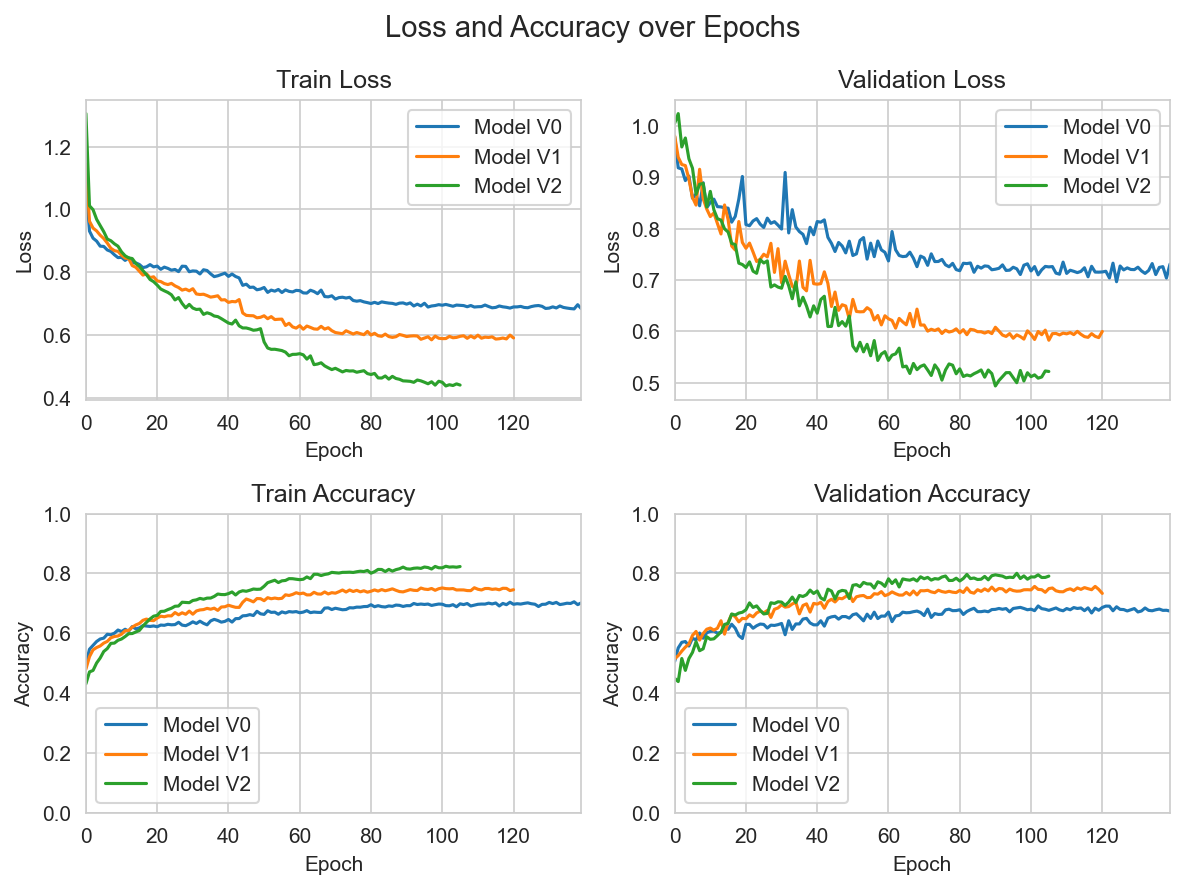

In [48]:
plot_losses_and_accuracies(df)

Based on this graph, Model V0 performs the worst in terms of both training and validation metrics, while Model V2 consistently achieves the lowest loss and highest accuracy across the entire training process.

## Plot correctly and incorrectly predicted samples

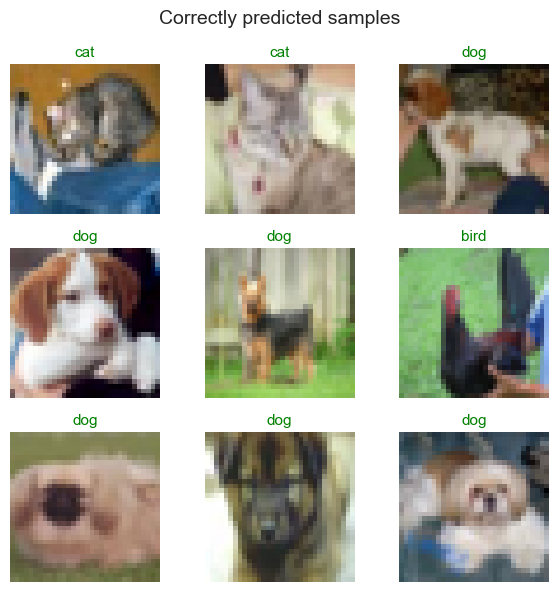

In [49]:
plot_correct_or_incorrect_samples(
    model=model2,
    dataloader=test_data_loader,
    classes=target_classes,
    correct=True,
    mean=img_mean,
    std=img_std,
)

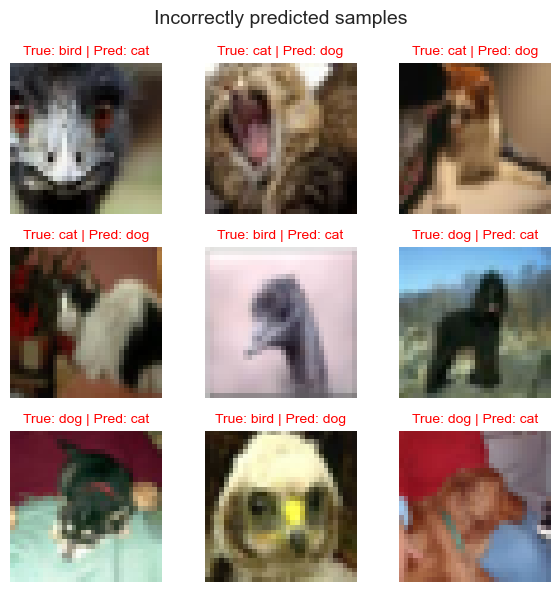

In [50]:
plot_correct_or_incorrect_samples(
    model=model2,
    dataloader=test_data_loader,
    classes=target_classes,
    correct=False,
    mean=img_mean,
    std=img_std,
)

The visualizations below show examples of both correctly and incorrectly classified test samples by the Model V2.  
Misclassifications are observed across all three classes (cat, dog, bird), indicating that errors are not limited to a single category. And the same is true for correctly predicted samples.

## Create a Random Guess Model

As a baseline, we define a simple model that produces random predictions for each input.  
This model does not learn from data and serves to evaluate how well a trained model performs compared to random guessing.  
If our trained models do not outperform this baseline, it indicates that they failed to learn meaningful patterns from the data.


In [51]:
dummy_model = RandomGuessModel(num_classes=len(target_classes))

## Confusion Matrices for All Models

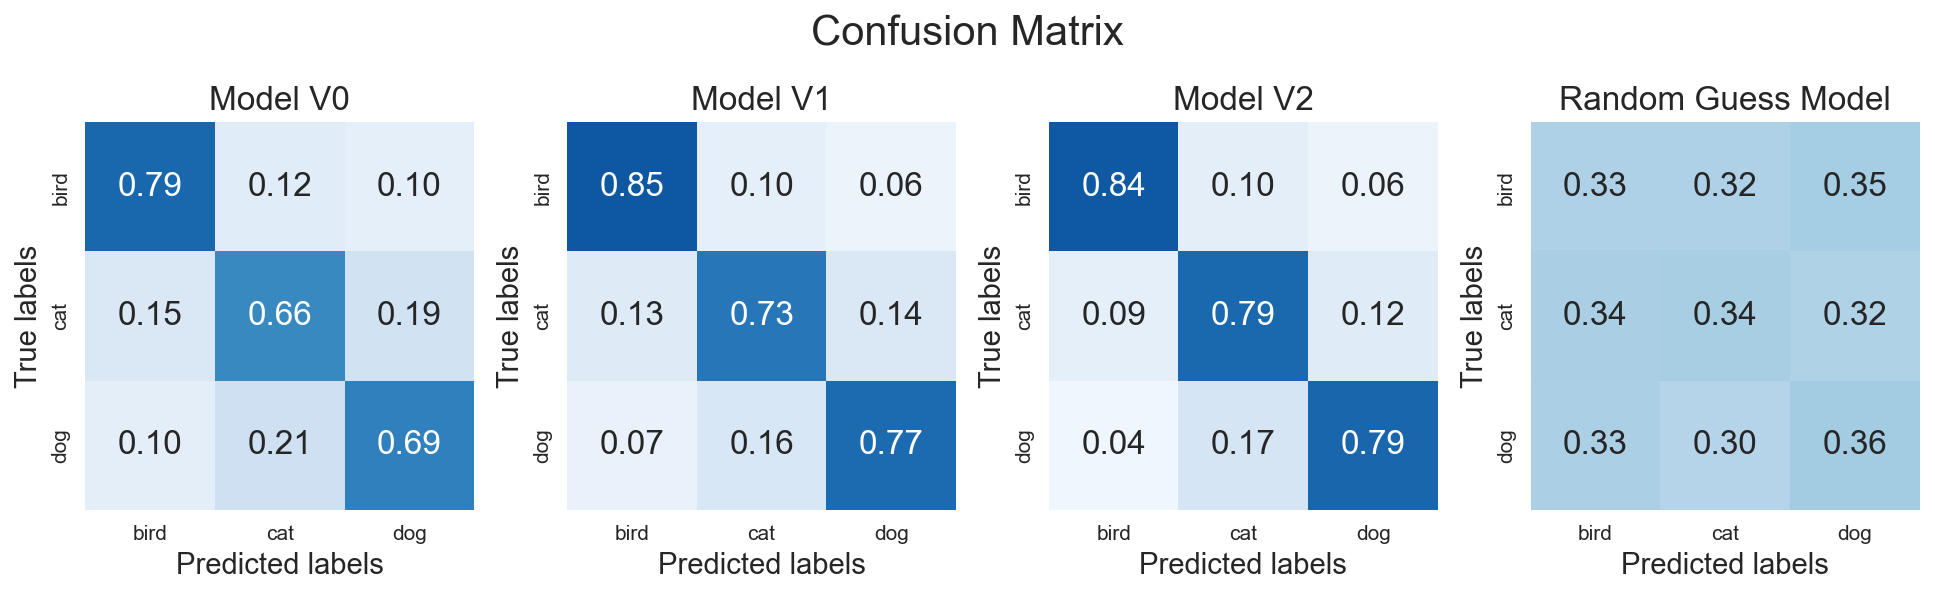

In [52]:
plt.figure(figsize=(13,4), dpi=150)

for i,m in enumerate([model0, model1, model2, dummy_model]):
    plt.subplot(1,4,1+i)
    plot_confusion_matrix(m, test_data_loader, target_classes, cbar=False)
    plt.title(f'Model V{i}', fontdict={'size':16})

plt.title('Random Guess Model', fontdict={'size':16})
plt.suptitle('Confusion Matrix', fontsize=20)
plt.tight_layout()
plt.show()

The heatmaps below show the normalized confusion matrices for all evaluated models, including the Random Guess baseline.

Each row is normalized (i.e., values sum to 1), allowing comparison of per-class performance.

As expected, Model V2 — the most complex version — shows the best overall classification performance, followed by V1 and V0.  
The Random Guess Model, which outputs uniform predictions, serves as a weak baseline.

Notably, all models struggle most with correctly classifying the **cat** class, which tends to be confused with both birds and dogs.


## F1-Macro Score Evaluation

To quantify classification performance beyond accuracy, the **F1-Macro score** for each model are computed.  
This metric calculates the F1 score independently for each class and then takes the unweighted average, treating all classes equally — regardless of their support in the dataset.

The table below compares all models, including the Random Guess baseline.

As expected, the deeper and more expressive Model V2 achieves the highest F1 score, while the Random Guess Model performs poorly, close to the chance level.  
Once again, we observe that increased model complexity leads to better generalization across all classes.


In [53]:
f1_model0 = calculate_f1_score(model0, test_data_loader, average='macro')
f1_model1 = calculate_f1_score(model1, test_data_loader, average='macro')
f1_model2 = calculate_f1_score(model2, test_data_loader, average='macro')
f1_dummy_model = calculate_f1_score(dummy_model, test_data_loader, average='macro')
df_f1 = pd.DataFrame({'Model':['Model V0', 'Model V1', 'Model V2', 'Random Guess Model'],
                      'F1-Macro': [f1_model0, f1_model1, f1_model2, f1_dummy_model]})
df_f1.sort_values(by='F1-Macro', ascending=False)

,Model,F1-Macro
2,Model V2,0.806659
1,Model V1,0.781490
0,Model V0,0.712452
3,Random Guess Model,0.336015


# Summary
This project explores and compares the performance of several custom-designed Convolutional Neural Network (CNN) models on a multiclass image classification task. The task involves classifying colored animal images into predefined categories using supervised learning with PyTorch.

### Key Components

- **Custom CNN Architectures (ModelV0, ModelV1, ModelV2)**: Three models with increasing depth and complexity, built using reusable `ConvStack` blocks. ModelV1 and ModelV2 includes additional non-linearity and regularization for improved generalization.
- **RandomGuessModel**: A baseline model that generates purely random predictions, used to validate that learned models outperform chance.
- **ModelUtilsMixin**: A utility class offering convenient methods for saving/loading weights, counting parameters, performing inference, and freezing models.
- **Evaluation Pipeline**:
  - Loss and accuracy tracking over training epochs.
  - Visualization of correct and incorrect predictions.
  - Confusion matrix analysis.
  - Macro F1-score computation for performance comparison.

### Insights

- Deeper models (ModelV2) generally yield higher accuracy and F1-scores.
- Visual ambiguity caused consistent confusion with certain classes (e.g., `cat`).
- The RandomGuessModel performed significantly worse, confirming the effectiveness of trained models.
- Visualization techniques provided intuitive understanding of how and where models fail.

### Conclusion

This project demonstrates a systematic, modular approach to image classification using PyTorch, showcasing best practices in model design, training, evaluation, and visualization. It also highlights the importance of baseline comparisons and interpretable metrics like F1-score and confusion matrices when assessing model quality.